<a href="https://colab.research.google.com/github/AbeerProg/RRDS/blob/main/CNN_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

df = pd.read_excel('Final_dataset.xlsx')

texts = df['review_text']
numerical_features = df.iloc[:, 1:11].values
labels = df['Label'].values

# Handle imbalanced data
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))

# Tokenization and padding for text data
max_len = 100
vocab_size = 10000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Train-test split
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    padded_sequences, numerical_features, labels, test_size=0.2, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)



In [3]:
from tensorflow.keras.layers import SimpleRNN

def build_rnn_model(vocab_size, max_len, num_numerical_features):

    text_input = Input(shape=(max_len,), name='text_input')
    embedding = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(text_input)
    rnn = SimpleRNN(128)(embedding)

     num_input = Input(shape=(num_numerical_features,), name='num_input')

     combined = Concatenate()([rnn, num_input])

     dense = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build and compile RNN model
rnn_model = build_rnn_model(vocab_size, max_len, X_train_num.shape[1])

# Train the RNN model
rnn_history = rnn_model.fit([X_train_text, X_train_num], y_train,
                            validation_split=0.2, epochs=3, batch_size=32,
                            class_weight=class_weights_dict)


Epoch 1/3
430/430 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.6760 - loss: 0.6241 - val_accuracy: 0.7465 - val_loss: 0.5123
Epoch 2/3
430/430 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.7647 - loss: 0.4792 - val_accuracy: 0.7712 - val_loss: 0.5040
Epoch 3/3
430/430 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.7811 - loss: 0.4664 - val_accuracy: 0.7710 - val_loss: 0.4582


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE

max_len = 100
vocab_size = 10000  # Limit vocabulary size to 10,000

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    padded_sequences, numerical_features, labels, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_combined, y_train = smote.fit_resample(np.hstack((X_train_text, X_train_num)), y_train)

X_train_text = X_train_combined[:, :max_len]
X_train_num = X_train_combined[:, max_len:]

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Input, Concatenate, SimpleRNN, LSTM


def build_cnn_model(vocab_size, max_len, num_numerical_features):
    # Text input branch
    text_input = Input(shape=(max_len,), name='text_input')
    embedding = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(text_input)
    conv = Conv1D(128, 5, activation='relu')(embedding)
    pool = MaxPooling1D(pool_size=2)(conv)
    text_output = GlobalMaxPooling1D()(pool)

    # Numerical input branch
    num_input = Input(shape=(num_numerical_features,), name='num_input')

    # Combine text and numerical branches
    combined = Concatenate()([text_output, num_input])

    # Dense layers for final classification
    dense = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build and train CNN model
cnn_model = build_cnn_model(vocab_size, max_len, X_train_num.shape[1])
cnn_history = cnn_model.fit([X_train_text, X_train_num], y_train, validation_split=0.2, epochs=10, batch_size=32)

# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate([X_test_text, X_test_num], y_test)
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8155 - loss: 0.4159 - val_accuracy: 0.8088 - val_loss: 0.3998
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8925 - loss: 0.2591 - val_accuracy: 0.7820 - val_loss: 0.4732
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9573 - loss: 0.1301 - val_accuracy: 0.7922 - val_loss: 0.5158
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9888 - loss: 0.0420 - val_accuracy: 0.7813 - val_loss: 0.6602
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9957 - loss: 0.0169 - val_accuracy: 0.8216 - val_loss: 0.5927
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9969 - loss: 0.0097 - val_accuracy: 0.7805 - val_loss: 0.8553
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9983 - loss: 0.0064 - val_accuracy: 0.7570 - val_loss: 1.0280
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9980 - loss: 0.0064 - val_acc

In [5]:
from tensorflow.keras.layers import SimpleRNN, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Input, Concatenate

def build_cnn_model(vocab_size, max_len, num_numerical_features):

     text_input = Input(shape=(max_len,), name='text_input')
    embedding = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(text_input)
    conv = Conv1D(128, 5, activation='relu')(embedding)
    pool = MaxPooling1D(pool_size=2)(conv)
    text_output = GlobalMaxPooling1D()(pool)

    num_input = Input(shape=(num_numerical_features,), name='num_input')

    combined = Concatenate()([text_output, num_input])

    dense = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build and train CNN model
cnn_model = build_cnn_model(vocab_size, max_len, X_train_num.shape[1])
cnn_history = cnn_model.fit([X_train_text, X_train_num], y_train, validation_split=0.2, epochs=10, batch_size=32)

# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate([X_test_text, X_test_num], y_test)
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")


Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8168 - loss: 0.4161 - val_accuracy: 0.8311 - val_loss: 0.3763
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8905 - loss: 0.2668 - val_accuracy: 0.8283 - val_loss: 0.3833
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9546 - loss: 0.1338 - val_accuracy: 0.7813 - val_loss: 0.5456
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9885 - loss: 0.0432 - val_accuracy: 0.7325 - val_loss: 0.8864
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9947 - loss: 0.0187 - val_accuracy: 0.8088 - val_loss: 0.6479
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9985 - loss: 0.0069 - val_accuracy: 0.7595 - val_loss: 0.9726
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9978 - loss: 0.0078 - val_accuracy: 0.7570 - val_loss: 1.0276
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9981 - loss: 0.0048 - val_accu

In [6]:
from tensorflow.keras.layers import SimpleRNN, LSTM
from tensorflow.keras.layers import SimpleRNN

def build_rnn_model(vocab_size, max_len, num_numerical_features):

     text_input = Input(shape=(max_len,), name='text_input')
    embedding = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(text_input)
    rnn = SimpleRNN(128)(embedding)

    num_input = Input(shape=(num_numerical_features,), name='num_input')

    combined = Concatenate()([rnn, num_input])

    dense = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build and train RNN model
rnn_model = build_rnn_model(vocab_size, max_len, X_train_num.shape[1])
rnn_history = rnn_model.fit([X_train_text, X_train_num], y_train, validation_split=0.2, epochs=10, batch_size=32)

# Evaluate the RNN model
rnn_loss, rnn_accuracy = rnn_model.evaluate([X_test_text, X_test_num], y_test)
print(f"RNN Test Accuracy: {rnn_accuracy:.4f}")


Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.7796 - loss: 0.4675 - val_accuracy: 0.8462 - val_loss: 0.3607
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8410 - loss: 0.3565 - val_accuracy: 0.8395 - val_loss: 0.3680
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8452 - loss: 0.3432 - val_accuracy: 0.8534 - val_loss: 0.3359
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8533 - loss: 0.3219 - val_accuracy: 0.8432 - val_loss: 0.3367
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.8616 - loss: 0.3074 - val_accuracy: 0.8851 - val_loss: 0.2660
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8697 - loss: 0.2916 - val_accuracy: 0.8806 - val_loss: 0.2762
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8833 - loss: 0.2700 - val_accuracy: 0.8462 - val_loss: 0.3256
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.8825 - loss: 0.2637 - 

In [8]:
from tensorflow.keras.layers import LSTM

def build_lstm_model(vocab_size, max_len, num_numerical_features):

    text_input = Input(shape=(max_len,), name='text_input')
    embedding = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(text_input)
    lstm = LSTM(128)(embedding)

    num_input = Input(shape=(num_numerical_features,), name='num_input')

    combined = Concatenate()([lstm, num_input])

    dense = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build and train LSTM model
lstm_model = build_lstm_model(vocab_size, max_len, X_train_num.shape[1])
lstm_history = lstm_model.fit([X_train_text, X_train_num], y_train, validation_split=0.2, epochs=10, batch_size=32)

# Evaluate the LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate([X_test_text, X_test_num], y_test)
print(f"LSTM Test Accuracy: {lstm_accuracy:.4f}")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


505/505 ━━━━━━━━━━━━━━━━━━━━ 49s 93ms/step - accuracy: 0.7965 - loss: 0.4404 - val_accuracy: 0.8459 - val_loss: 0.3477
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 47s 92ms/step - accuracy: 0.8587 - loss: 0.3196 - val_accuracy: 0.8791 - val_loss: 0.2859
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - accuracy: 0.8773 - loss: 0.2802 - val_accuracy: 0.8551 - val_loss: 0.3246
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 48s 96ms/step - accuracy: 0.8913 - loss: 0.2563 - val_accuracy: 0.8764 - val_loss: 0.2852
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 48s 95ms/step - accuracy: 0.8955 - loss: 0.2461 - val_accuracy: 0.8675 - val_loss: 0.2990
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.8963 - loss: 0.2408 - val_accuracy: 0.8987 - val_loss: 0.2429
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 47s 92ms/step - accuracy: 0.9032 - loss: 0.2291 - val_accuracy: 0.8890 - val_loss: 0.2708
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.9028 - loss: 0.2244 - val_accurac

In [9]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

 cnn_predictions = cnn_model.predict([X_test_text, X_test_num])
cnn_predictions = (cnn_predictions > 0.5).astype(int)

rnn_predictions = rnn_model.predict([X_test_text, X_test_num])
rnn_predictions = (rnn_predictions > 0.5).astype(int)

lstm_predictions = lstm_model.predict([X_test_text, X_test_num])
lstm_predictions = (lstm_predictions > 0.5).astype(int)

# Accuracy
cnn_accuracy = accuracy_score(y_test, cnn_predictions)
rnn_accuracy = accuracy_score(y_test, rnn_predictions)
lstm_accuracy = accuracy_score(y_test, lstm_predictions)

# Classification Reports
print("CNN Classification Report:\n", classification_report(y_test, cnn_predictions))
print("RNN Classification Report:\n", classification_report(y_test, rnn_predictions))
print("LSTM Classification Report:\n", classification_report(y_test, lstm_predictions))

# AUC-ROC
cnn_auc = roc_auc_score(y_test, cnn_predictions)
rnn_auc = roc_auc_score(y_test, rnn_predictions)
lstm_auc = roc_auc_score(y_test, lstm_predictions)

# Print AUC-ROC scores
print(f"CNN AUC-ROC: {cnn_auc:.4f}")
print(f"RNN AUC-ROC: {rnn_auc:.4f}")
print(f"LSTM AUC-ROC: {lstm_auc:.4f}")


135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      2491
           1       0.86      0.72      0.79      1805

    accuracy                           0.84      4296
   macro avg       0.84      0.82      0.83      4296
weighted avg       0.84      0.84      0.83      4296

RNN Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      2491
           1       0.87      0.86      0.87      1805

    accuracy                           0.89      4296
   macro avg       0.89      0.88      0.89      4296
weighted avg       0.89      0.89      0.89      4296

LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      2491
           1       0.90    

In [10]:
import pandas as pd

# Store the results in a dictionary
results = {
    "Model": ["CNN", "RNN", "LSTM"],
    "Accuracy": [cnn_accuracy, rnn_accuracy, lstm_accuracy],
    "AUC-ROC": [cnn_auc, rnn_auc, lstm_auc],
}

# Create a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


  Model  Accuracy   AUC-ROC
0   CNN  0.835428  0.819794
1   RNN  0.888734  0.884831
2  LSTM  0.903631  0.898592


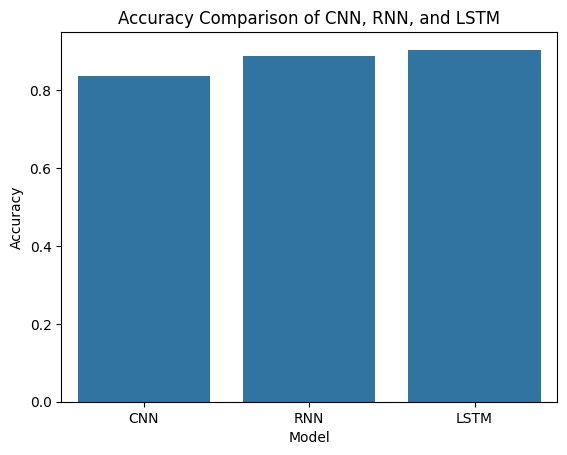

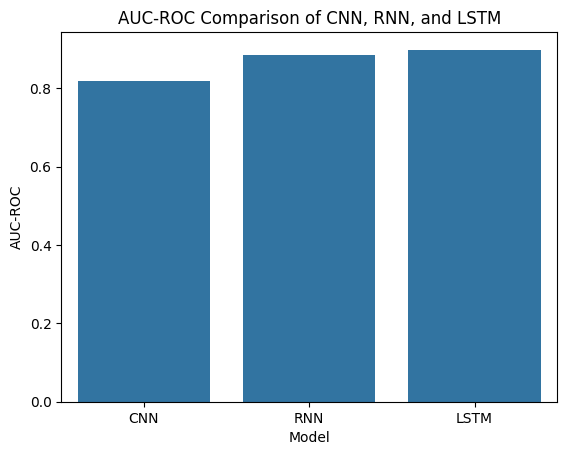

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the comparison for Accuracy
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Accuracy Comparison of CNN, RNN, and LSTM')
plt.show()

# Plot the comparison for AUC-ROC
sns.barplot(x='Model', y='AUC-ROC', data=results_df)
plt.title('AUC-ROC Comparison of CNN, RNN, and LSTM')
plt.show()


In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cnn_accuracies = []
rnn_accuracies = []
lstm_accuracies = []

# Perform manual cross-validation
for train_index, test_index in kf.split(X_train_combined):
    X_train_fold, X_test_fold = X_train_combined[train_index], X_train_combined[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # CNN model
    cnn_model = build_cnn_model(vocab_size, max_len, X_train_num.shape[1])
    cnn_model.fit([X_train_fold[:, :max_len], X_train_fold[:, max_len:]], y_train_fold, epochs=5, batch_size=32, verbose=0)
    cnn_predictions = (cnn_model.predict([X_test_fold[:, :max_len], X_test_fold[:, max_len:]]) > 0.5).astype(int)
    cnn_accuracies.append(accuracy_score(y_test_fold, cnn_predictions))

    # RNN model
    rnn_model = build_rnn_model(vocab_size, max_len, X_train_num.shape[1])
    rnn_model.fit([X_train_fold[:, :max_len], X_train_fold[:, max_len:]], y_train_fold, epochs=5, batch_size=32, verbose=0)
    rnn_predictions = (rnn_model.predict([X_test_fold[:, :max_len], X_test_fold[:, max_len:]]) > 0.5).astype(int)
    rnn_accuracies.append(accuracy_score(y_test_fold, rnn_predictions))

    # LSTM model
    lstm_model = build_lstm_model(vocab_size, max_len, X_train_num.shape[1])
    lstm_model.fit([X_train_fold[:, :max_len], X_train_fold[:, max_len:]], y_train_fold, epochs=5, batch_size=32, verbose=0)
    lstm_predictions = (lstm_model.predict([X_test_fold[:, :max_len], X_test_fold[:, max_len:]]) > 0.5).astype(int)
    lstm_accuracies.append(accuracy_score(y_test_fold, lstm_predictions))

# Calculate and print the average accuracy for each model
print(f"CNN Average Accuracy: {np.mean(cnn_accuracies):.4f}")
print(f"RNN Average Accuracy: {np.mean(rnn_accuracies):.4f}")
print(f"LSTM Average Accuracy: {np.mean(lstm_accuracies):.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


127/127 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step
CNN Average Accuracy: 0.8411
RNN Average Accuracy: 0.8740
LSTM Average Accuracy: 0.8891
